In [5]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from itertools import combinations

from nets_algo import *

## Функция потерь

Создание функции потерь в torch
https://neptune.ai/blog/pytorch-loss-functions. Для задач бинарной классификации рекомендуют использовать CrossEntropy функцию потерь

In [2]:
loss_fn = nn.BCELoss()

# Загрузка и подговтовка данных

In [3]:
data = pd.read_csv(
    "/home/dranik/KFA/university/proc_2.csv", 
    index_col = 0
)

# save_ind = data[data['Y'] == 0].sample(
#     sum(data['Y']), random_state = 0
# ).index.union(data[data['Y'] == 1].index)
# data = data.loc[save_ind]

Нужно провести One Hot Encoding

In [6]:
Y = np.array(data[['Y']])
X = data.drop('Y', axis = 1)

X = np.concatenate([
    OneHotEncoder(sparse = False).\
    fit_transform(X.loc[:,X.dtypes == "O"]),
    X.loc[:,X.dtypes != "O"].to_numpy()
], axis = 1)

X = normalize(X)

Разбивка на Train/Test

In [7]:
X_train, X_test, y_train, y_test = \
    train_test_split(
        X,Y, random_state = 0, stratify = Y
)

## Создание набора данных и загрузчика данных

In [8]:
train_data = My_data_set(
    torch.tensor(X_train.astype('float32')), 
    torch.tensor(y_train.astype('float32'))
)

In [9]:
train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=1000
)

# Различные варианты модели

## Модели с одним скрытым слоем

Опишем вещи общие для модлей этой группы

In [10]:
import os

sfn = "fiting_results2/"
auc_full = pd.DataFrame()

In [11]:
def save_folder_porecessor(result_name):
    if not result_name in os.listdir("fiting_results2"):
        os.mkdir("fiting_results2/" + result_name)

def model_info_save(
    hlr, epochs, file_name, 
    lc_plot_param = {},
    fit_params = {}
):
    learning_info, auc_info, nets = \
    models_fit_get_perfomance(
        hlr, epochs, loss_fn, 
        train_data_loader, X_test, y_test,
        **fit_params
    )
    
    save_folder_porecessor(file_name)
    learning_info.to_excel(sfn + file_name + '/lc.xlsx')
    
    global auc_full
    if any(auc_full.columns == file_name):
        auc_full.drop(
            file_name, inplace = True, axis = 1
        )
        
    auc_full = auc_full.join(
        pd.DataFrame(auc_info, columns = [file_name]),
        how = 'outer'
    )
    
    for col in learning_info:

        fig = plt.figure(figsize = [14, 7])
        plot_learning_curve(
            learning_info[col],
            **lc_plot_param
        )
        fig.savefig(
            sfn + file_name + "/" +\
            str(col) + '.png'
        )
        plt.close()
    
    return nets

def lc_plot_report_to_file(
    lc, file_name, auc, lc_param = {}
):
    '''настроенная по размерам кривая обучения
     в файл с AUC в загоровке в файл'''
    
    fig = plt.figure(figsize = [13, 7])
    plot_learning_curve(
        np.array(lc), **lc_param
    )
    fig.suptitle("AUC = " + str(auc))
    plt.savefig(file_name)


Наиболее гибкое получение модели и оптимизатора в одну строку

In [12]:
def get_main_parts(
    data_loader_param = {'batch_size': 500},
    hidden_layers = [2],
    optimizer_param = {}
):
    '''получить сеть и оптимизатор одной строкой'''
    train_data_loader =\
    torch.utils.data.DataLoader(
        train_data, **data_loader_param
    )

    torch.manual_seed(0)

    net = ResultNet(
        [train_data_loader.dataset.X.shape[1]] +\
        hidden_layers
    )

    optimizer = optim.Adam(
        net.parameters(),
        **optimizer_param
    )
    
    return [train_data_loader, net, optimizer] 

### Обобщенный построитель модели с одним слоем

Базовый вариант

In [15]:
torch.manual_seed(0)

nets = model_info_save(
    [[i] for i in range(2, 20)],
    20, "one_hiden_initial",
    lc_plot_param = {'last_spes_show':3},
    fit_params = {'lr':0.001}
)

[2] AUC = 0.6701360009844674
[3] AUC = 0.6500812746343632
[4] AUC = 0.6485926967969513
[5] AUC = 0.6551288137796384
[6] AUC = 0.6644289611528031
[7] AUC = 0.6490692594490217
[8] AUC = 0.652777012557566
[9] AUC = 0.6391411183006986
[10] AUC = 0.6457943552151856
[11] AUC = 0.655349692073554
[12] AUC = 0.6504115198505087
[13] AUC = 0.6611095183533532
[14] AUC = 0.6551331026785494
[15] AUC = 0.6557422912815594
[16] AUC = 0.6523700620339741
[17] AUC = 0.6528118186218053
[18] AUC = 0.6526692952118403
[19] AUC = 0.658109928438072


Понижение learning rate

In [38]:
torch.manual_seed(0)

nets = model_info_save(
    [[i] for i in range(2, 20)],
    50, "one_hiden_lr_0.01",
    fit_params = {'lr':0.01}
)

[2] AUC = 0.644856076099583
[3] AUC = 0.6276041451878057
[4] AUC = 0.6499595358883513
[5] AUC = 0.6597085330283157
[6] AUC = 0.6600552740095035
[7] AUC = 0.6471428840073888
[8] AUC = 0.6593113150060985
[9] AUC = 0.680565448432424
[10] AUC = 0.6797301028906849
[11] AUC = 0.6697729291958875
[12] AUC = 0.6693465136695456
[13] AUC = 0.6737625949290039
[14] AUC = 0.6768702321053116
[15] AUC = 0.6781775214849091
[16] AUC = 0.6773253502628269
[17] AUC = 0.6209433202213996
[18] AUC = 0.6843243384125993
[19] AUC = 0.6834515474842144


In [39]:
torch.manual_seed(0)

nets = model_info_save(
    [[i] for i in range(2, 20)],
    50, "one_hiden_lr_0.001",
    fit_params = {'lr':0.001}
)

[2] AUC = 0.6582315022264335
[3] AUC = 0.6030587767202527
[4] AUC = 0.6416803114136508
[5] AUC = 0.6060250451901482
[6] AUC = 0.6271297269851912
[7] AUC = 0.6378419118459718
[8] AUC = 0.552448944782406
[9] AUC = 0.5719091637603877
[10] AUC = 0.6317140650480803
[11] AUC = 0.6187427851647647
[12] AUC = 0.6423035214169467
[13] AUC = 0.5814760476542857
[14] AUC = 0.6074327937788531
[15] AUC = 0.5864147147502822
[16] AUC = 0.6317201684811459
[17] AUC = 0.6143603552659926
[18] AUC = 0.6388336372403113
[19] AUC = 0.6269646043771183


По моему мнению самой перспективной в данном случае моделью должна стать 18 нейронов.

In [40]:
[train_data_loader, net_18, optimizer] = get_main_parts(
    data_loader_param = {"batch_size":100},
    hidden_layers = [18],
    optimizer_param = {
        'weight_decay':0.5, 
        'lr':0.01
    }
)


lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, 0.95
)

lc = train(
    net_18, optimizer, loss_fn,
    train_data_loader, epochs = 500,
    lr_scheduler = lr_scheduler
)

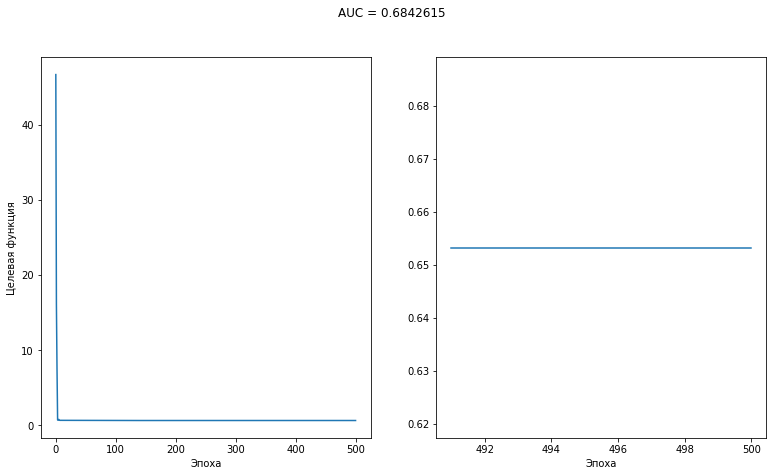

In [41]:
probs_hat = net_18(
    torch.tensor(X_test.astype('float32'))
).detach().numpy()

auc = roc_auc_score(y_test, probs_hat)

lc_plot_report_to_file(
    lc, "fiting_results2/manual_models_results/18_test.png",
    np.round(auc, 7),
    lc_param = {
        'start_show':0,
        'last_spes_show':10
    }
)

Результаты ее обучния показали, что можно выйграть в AUC за счет размера batch. Потому попробуем переучить некоторые старые модели с меньшим batch и попробуем ряд моделей с большим числом нейронов

## 10-30 нейронов батч 500

In [42]:
train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=500
)

In [43]:
torch.manual_seed(0)

nets = model_info_save(
    [[i] for i in range(10, 31)],
    50, "one_hiden_batch_500_lr_0.01",
    fit_params = {'lr':0.01}
)

[10] AUC = 0.6803585915387943
[11] AUC = 0.675033758583159
[12] AUC = 0.6168530303215255
[13] AUC = 0.6322147115171123
[14] AUC = 0.6775853235198928
[15] AUC = 0.6737914625178278
[16] AUC = 0.6739928758089936
[17] AUC = 0.6760993850048876
[18] AUC = 0.6802365228774817
[19] AUC = 0.5207086184763785
[20] AUC = 0.6817117391452092
[21] AUC = 0.6805631390253181
[22] AUC = 0.6034983888586284
[23] AUC = 0.6622881407656213
[24] AUC = 0.6601105348223951
[25] AUC = 0.6782636293784297
[26] AUC = 0.6594215067165807
[27] AUC = 0.6688207936376493
[28] AUC = 0.6819086985798135
[29] AUC = 0.6752914224331188
[30] AUC = 0.6631627462281608


В целом все понятно - сразу уменьшать learning rate

In [44]:
torch.manual_seed(0)

nets = model_info_save(
    [[i] for i in range(10, 31)],
    50, "one_hiden_batch_500_lr_0.001",
    fit_params = {'lr':0.001}
)

[10] AUC = 0.611170734137425
[11] AUC = 0.661563646764966
[12] AUC = 0.6214296153748448
[13] AUC = 0.6333138243418767
[14] AUC = 0.5148676330325715
[15] AUC = 0.6516402893885053
[16] AUC = 0.6225742565111259
[17] AUC = 0.6317407881874486
[18] AUC = 0.6106453440208295
[19] AUC = 0.5136880208744008
[20] AUC = 0.6125002927998294
[21] AUC = 0.6313349923674095
[22] AUC = 0.6120073993403674
[23] AUC = 0.6223987415710764
[24] AUC = 0.631103226868566
[25] AUC = 0.6340183584668309
[26] AUC = 0.6499986308515016
[27] AUC = 0.48516766790461885
[28] AUC = 0.5637092839155404
[29] AUC = 0.6112043854981111
[30] AUC = 0.5804584239088298


In [45]:
[train_data_loader, net_10, optimizer] = get_main_parts(
    data_loader_param = {"batch_size":50},
    hidden_layers = [10],
    optimizer_param = {
        'weight_decay':0.5, 
        'lr':0.01
    }
)

lr_scheduler = torch.optim.lr_scheduler.ChainedScheduler(
    schedulers = [
        optim.lr_scheduler.ExponentialLR(
            optimizer, 0.7
        ),
        optim.lr_scheduler.StepLR(
            optimizer, 12, 0.5
        )
    ]
)

lc = train(
    net_10, optimizer, loss_fn,
    train_data_loader, epochs = 25,
    lr_scheduler = lr_scheduler
)

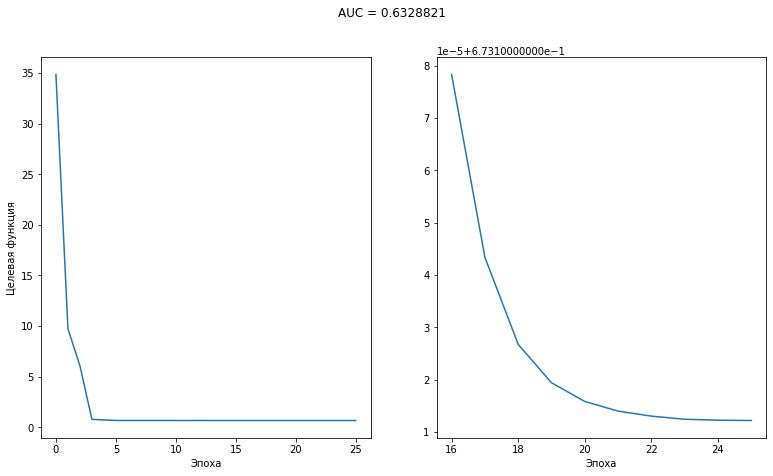

In [46]:
probs_hat = net_10(
    torch.tensor(X_test.astype('float32'))
).detach().numpy()

auc = roc_auc_score(y_test, probs_hat)

lc_plot_report_to_file(
    lc, "fiting_results2/manual_models_results/18_test.png",
    np.round(auc, 7),
    lc_param = {
        'start_show':0,
        'last_spes_show':10
    }
)

В целом неполучается добиться улучшений - возьмем текущее состояние модели с 18 нейронами и доучим её, чтобы выжать максимум. Предполагая, что все локальные минимумы мы уже обошли увеличим размер батча и приблизимся к еще более точному решению оптимизационной задачи

In [47]:
from copy import deepcopy

final_net = deepcopy(net_18)

torch.manual_seed(0)

optimizer = optim.Adam(
    final_net.parameters(),
    weight_decay = 0.2,
    lr = 0.00001
)

lr_scheduler = \
optim.lr_scheduler.ChainedScheduler(
    [
        optim.lr_scheduler.ExponentialLR(optimizer, 0.65),
        optim.lr_scheduler.StepLR(optimizer, 38, 0.1)
    ]
)

train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=3000
)

lc = train(
    final_net, optimizer, loss_fn,
    train_data_loader, epochs = 50,
    lr_scheduler = lr_scheduler
)

0.6860422073840983

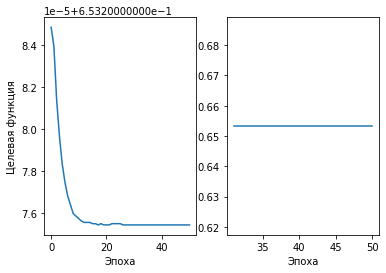

In [48]:
plot_learning_curve(
    np.array(lc), start_show = 0, last_spes_show = 20
)

probs_hat = final_net(
    torch.tensor(X_test.astype('float32'))
).detach().numpy()

auc = roc_auc_score(y_test, probs_hat)
auc

Тут уже как не крути, к 100 эпохе модель неизбежно выходит на плато потому думаю стоит прекращать исследование в этом направлении.

## Модели с двумя скрытыми слоями

In [49]:
auc_full = pd.DataFrame()

Нужно вернуть настройки батча

In [50]:
train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=100
)

Варианты числа нейронов в крытых слоях

In [51]:
first_layer_var = [50, 60, 70]
second_layer_var = [40, 50 , 60]

variants = []
for first_l in first_layer_var:
    for second_l in second_layer_var:
        variants.append([first_l, second_l])

Базовые модели с двумя слоями

In [52]:
torch.manual_seed(0)

nets = model_info_save(
    variants,
    50, "two_hiden_initial",
    lc_plot_param = {'start_show' : 0, 'last_spes_show': 5},
    fit_params = {'lr':0.001}
)

[50, 40] AUC = 0.6837405532877545
[50, 50] AUC = 0.6829669019072734
[50, 60] AUC = 0.6824603169628262
[60, 40] AUC = 0.6823300004189924
[60, 50] AUC = 0.682179064168856
[60, 60] AUC = 0.6829817480958114
[70, 40] AUC = 0.6829581591518009
[70, 50] AUC = 0.6820304373258254
[70, 60] AUC = 0.6828148109535839


In [53]:
torch.manual_seed(5)

[train_data_loader, net_60_40, optimizer] = get_main_parts(
    data_loader_param = {"batch_size":100},
    hidden_layers = [60, 40],
    optimizer_param = {
        'weight_decay':0.5, 
        'lr':0.01
    }
)


lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, 0.98
)

lc = train(
    net_60_40, optimizer, loss_fn,
    train_data_loader, epochs = 500,
    lr_scheduler = lr_scheduler
)

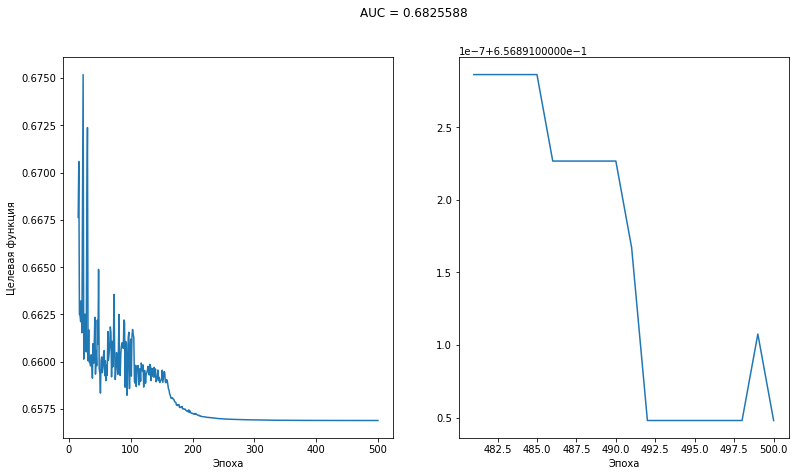

In [54]:
probs_hat = net_60_40(
    torch.tensor(X_test.astype('float32'))
).detach().numpy()

auc = roc_auc_score(y_test, probs_hat)

lc_plot_report_to_file(
    lc, "fiting_results2/manual_models_results/60_40_test.png",
    np.round(auc, 7),
    lc_param = {
        'start_show':15,
        'last_spes_show':20
    }
)

In [55]:
train_data_loader =\
torch.utils.data.DataLoader(
    train_data, batch_size=3000
)

lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, 0.5
)

lc = train(
    net_60_40, optimizer, loss_fn,
    train_data_loader, epochs = 20,
    lr_scheduler = lr_scheduler
)